In [1]:
import os                            
import numpy   as np                 
import pandas  as pd                
from matplotlib import pyplot as plt 
import seaborn as sns                
sns.set()                           
import tensorflow as tf                                                   
from   tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 


In [2]:
train_start_date = "2015-04-28"
train_end_date   = "2017-12-31"
val_start_date   = "2018-01-03"
val_end_date     = "2018-12-31"
test_start_date  = "2019-01-02"
test_end_date    = "2020-01-31"

In [3]:
all_data = pd.read_csv('all_close_volume.csv',  header = 0 , parse_dates = True, index_col = 0)



all_data['amzn_return'] = all_data['amzn_close'] / all_data['amzn_close'].shift() - 1

all_data['fb_return'] = all_data['fb_close'] / all_data['fb_close'].shift() - 1

all_data['intc_return'] = all_data['intc_close'] / all_data['intc_close'].shift() - 1

In [5]:
all_data['amzn_label'] = np.where(all_data['amzn_return'] > 0, 1, 0)

all_data['fb_label'] = np.where(all_data['fb_return'] > 0, 1, 0)

all_data['intc_label'] = np.where(all_data['intc_return'] > 0, 1, 0)

In [6]:
all_data["amzn_std_return"] = (all_data['amzn_return'] - all_data['amzn_return'][:val_start_date].mean()) / all_data['amzn_return'][:val_start_date].std()
all_data["amzn_std_volume"] = (all_data["amzn_volume"] - all_data["amzn_volume"].rolling(50).mean()) / all_data["amzn_volume"].rolling(50).std()
all_data["fb_std_return"] = (all_data['fb_return'] - all_data['fb_return'][:val_start_date].mean()) / all_data['fb_return'][:val_start_date].std()
all_data["fb_std_volume"] = (all_data["fb_volume"] - all_data["fb_volume"].rolling(50).mean()) / all_data["fb_volume"].rolling(50).std()
all_data["intc_std_return"] = (all_data['intc_return'] - all_data['intc_return'][:val_start_date].mean()) / all_data['intc_return'][:val_start_date].std()
all_data["intc_std_volume"] = (all_data["intc_volume"] - all_data["intc_volume"].rolling(50).mean()) / all_data["intc_volume"].rolling(50).std()


In [7]:
all_data.dropna(inplace = True)
all_data.head()

,amzn_close,amzn_volume,fb_close,fb_volume,intc_close,intc_volume,amzn_return,fb_return,intc_return,amzn_label,fb_label,intc_label,amzn_std_return,amzn_std_volume,fb_std_return,fb_std_volume,intc_std_return,intc_std_volume
date,,,,,,,,,,,,,,,,,,
2015-04-27,438.559998,5430900,81.910004,25446000,32.500000,25869600,-0.014693,0.004661,0.013092,0,1,1,-0.945425,0.998142,0.216846,-0.085915,0.923557,-0.396081
2015-04-28,429.309998,4140500,80.680000,23775300,33.020000,29572800,-0.021092,-0.015017,0.016000,0,0,1,-1.313774,0.429387,-1.068915,-0.254491,1.136361,-0.190070
2015-04-29,429.369995,3621700,80.470001,26430300,32.889999,21819000,0.000140,-0.002603,-0.003937,1,0,0,-0.091499,0.204200,-0.257783,-0.005027,-0.322712,-0.661090
2015-04-30,421.779999,3647900,78.769997,28999000,32.549999,22013300,-0.017677,-0.021126,-0.010337,0,0,0,-1.117193,0.206930,-1.468115,0.226284,-0.791124,-0.652965
2015-05-01,422.869995,3565800,78.989998,24136400,33.419998,27091200,0.002584,0.002793,0.026728,1,1,1,0.049230,0.165858,0.094789,-0.201021,1.921486,-0.371837


In [9]:
val_start_iloc  = all_data.index.get_loc(val_start_date,  method = 'bfill') 
test_start_iloc = all_data.index.get_loc(test_start_date, method = 'bfill' )

In [10]:
train_generator = TimeseriesGenerator(all_data[["amzn_std_return", "amzn_std_volume", "fb_std_return", "fb_std_volume", "intc_std_return", "intc_std_volume"]].values, all_data[["intc_label"]].values,
                                      length = 7, batch_size = 64, end_index = val_start_iloc-1)
val_generator   = TimeseriesGenerator(all_data[["amzn_std_return", "amzn_std_volume", "fb_std_return", "fb_std_volume", "intc_std_return", "intc_std_volume"]].values, all_data[["intc_label"]].values,
                                    length = 7, batch_size = 64, start_index = val_start_iloc,
                                    end_index = test_start_iloc-1)
test_generator = TimeseriesGenerator(all_data[["amzn_std_return", "amzn_std_volume", "fb_std_return", "fb_std_volume", "intc_std_return", "intc_std_volume"]].values, all_data[["intc_label"]].values,
                                     length = 7, batch_size = 64, start_index = test_start_iloc)

In [11]:
def model_fn(params):
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(params["lstm_size"], input_shape = (7, 6))) 
    model.add(tf.keras.layers.Dropout(params["dropout"])) #  regularisation
    model.add(tf.keras.layers.Dropout(params["dropout"]))
    model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))
    
    model.compile(optimizer = tf.keras.optimizers.Adam(params["learning_rate"]),
                  loss = "binary_crossentropy", metrics = ["accuracy"])            

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 5,
                                                  restore_best_weights = True)]
    history   = model.fit_generator(train_generator, validation_data = val_generator,
                                  callbacks = callbacks, epochs = 100, verbose = 0).history
    
    return (history, model)

In [12]:
def random_search(model_fn, search_space, n_iter, search_dir):
    
    results = [] 
    
    os.mkdir(search_dir) 
    
    best_model_path = os.path.join(search_dir, "best_model.h5")
    results_path    = os.path.join(search_dir, "results.csv")
    
    for i in range(n_iter):
        
        params           = {k: v[np.random.randint(len(v))] for k, v in search_space.items()}
        history, model   = model_fn(params)
        epochs           = np.argmax(history["val_accuracy"]) + 1
        result           = {k: v[epochs - 1] for k, v in history.items()}
        params["epochs"] = epochs
        
        if i == 0:
            
            best_val_accuracy = result["val_accuracy"]
            model.save(best_model_path)
            
        if result["val_accuracy"] > best_val_accuracy:
            best_val_accuracy = result["val_accuracy"]
            model.save(best_model_path)
            
        result = {**params, **result}
        results.append(result)
        tf.keras.backend.clear_session()
        print(f"iteration {i + 1} – {', '.join(f'{k}:{v:.4g}' for k, v in result.items())}")
        
    best_model = tf.keras.models.load_model(best_model_path)
    results    = pd.DataFrame(results)
    
    results.to_csv(results_path)
    
    return (results, best_model)

In [13]:
search_space = {"lstm_size":     np.linspace(50, 200, 3, dtype = int),
                "dropout":       np.linspace(0, 0.4, 2),
                "learning_rate": np.linspace(0.004, 0.01, 5)}

In [14]:
iterations          = 20
results, best_model = random_search(model_fn, search_space, iterations, "search_new")

C:\Users\lokes\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


iteration 1 – lstm_size:200, dropout:0, learning_rate:0.0085, epochs:4, loss:0.6654, accuracy:0.6021, val_loss:0.6963, val_accuracy:0.5473
iteration 2 – lstm_size:50, dropout:0, learning_rate:0.007, epochs:2, loss:0.6758, accuracy:0.5738, val_loss:0.6988, val_accuracy:0.5267
iteration 3 – lstm_size:125, dropout:0, learning_rate:0.007, epochs:1, loss:0.6998, accuracy:0.5276, val_loss:0.6901, val_accuracy:0.5514
iteration 4 – lstm_size:125, dropout:0, learning_rate:0.0085, epochs:5, loss:0.655, accuracy:0.611, val_loss:0.7139, val_accuracy:0.5391
iteration 5 – lstm_size:50, dropout:0.4, learning_rate:0.0085, epochs:2, loss:0.6918, accuracy:0.5544, val_loss:0.6932, val_accuracy:0.5432
iteration 6 – lstm_size:125, dropout:0, learning_rate:0.0085, epochs:10, loss:0.5096, accuracy:0.7437, val_loss:0.9278, val_accuracy:0.5597
iteration 7 – lstm_size:200, dropout:0.4, learning_rate:0.01, epochs:1, loss:0.7106, accuracy:0.5171, val_loss:0.7026, val_accuracy:0.4979
iteration 8 – lstm_size:200, d

In [15]:
results.sort_values("val_accuracy", ascending = False).head()

,lstm_size,dropout,learning_rate,epochs,loss,accuracy,val_loss,val_accuracy
15,200,0.4,0.0100,6,0.679721,0.575261,0.704499,0.588477
16,50,0.0,0.0100,8,0.617130,0.642325,0.759704,0.567901
12,125,0.0,0.0055,6,0.639735,0.614009,0.706307,0.559671
5,125,0.0,0.0085,10,0.509570,0.743666,0.927806,0.559671
18,125,0.0,0.0055,6,0.639527,0.645306,0.728834,0.555556


In [16]:
best_model.evaluate_generator(test_generator)

C:\Users\lokes\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.7208316922187805, 0.5364963412284851]

In [17]:
heatmap_data=all_data[['amzn_std_return','amzn_std_volume','fb_std_return','fb_std_volume','intc_std_return','intc_std_volume','intc_label']].copy()

Text(0.5, 1, 'Correlation of different variables to Intel price movement')

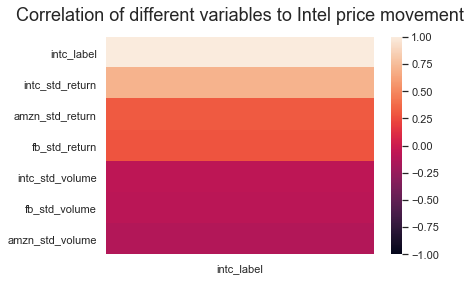

In [18]:
heatmap=sns.heatmap(heatmap_data.corr()[['intc_label']].sort_values(by='intc_label', ascending=False), vmin=-1, vmax=1, annot=False)
heatmap.set_title('Correlation of different variables to Intel price movement', fontdict={'fontsize':18}, pad=16)